In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import get_label_from_image_path, load_image_array, check_str, train_generator, valid_generator

### Setting the directory path for the dataset 

In [2]:
datadir = Path("/home/kalfasyan/data/images/fruit/")
# Inside my "fruit" folder I have "Test" and "Training" from the downloaded archive

### Defining a list of all training data paths and their labels

In [3]:
train_images = list(Path(os.path.join(datadir, 'Training')).rglob('*.jpg'))
train_labels = list(map(get_label_from_image_path, train_images)) 
train_labels = pd.Series(train_labels).apply(lambda x: check_str(x)) # ignore this; I just reduced the number of classes by renaming e.g. Pear 2 => Pear

test_images = list(Path(os.path.join(datadir, 'Test')).rglob('*.jpg'))
test_labels = list(map(get_label_from_image_path, train_images)) 
test_labels = pd.Series(test_labels).apply(lambda x: check_str(x)) # ignore this; I just reduced the number of classes by renaming e.g. Pear 2 => Pear

nb_classes = train_labels.unique().shape[0]

##### Checking value counts for each class

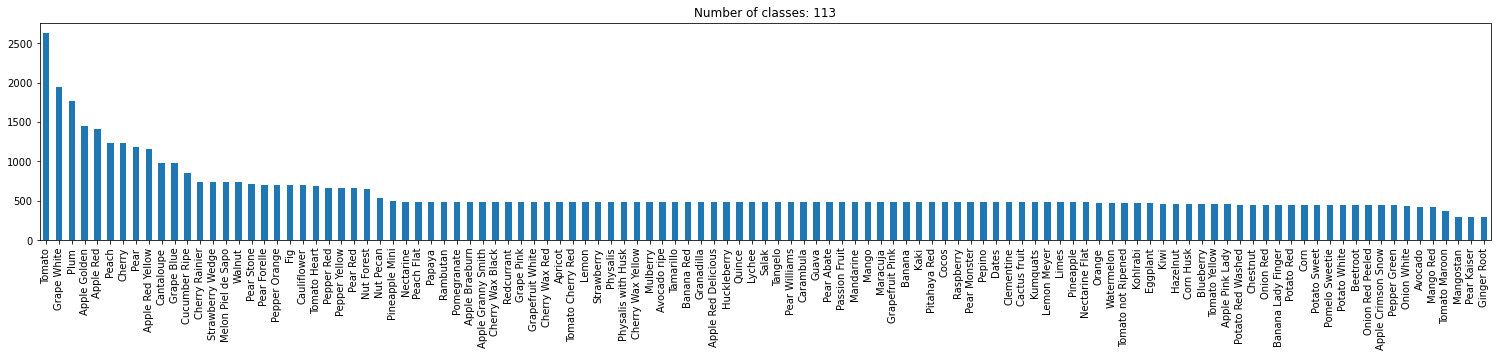

In [4]:
train_labels.value_counts().plot(kind='bar', figsize=(26,4));
plt.title(f"Number of classes: {nb_classes}");

### Grab 25 items randomly and plot them

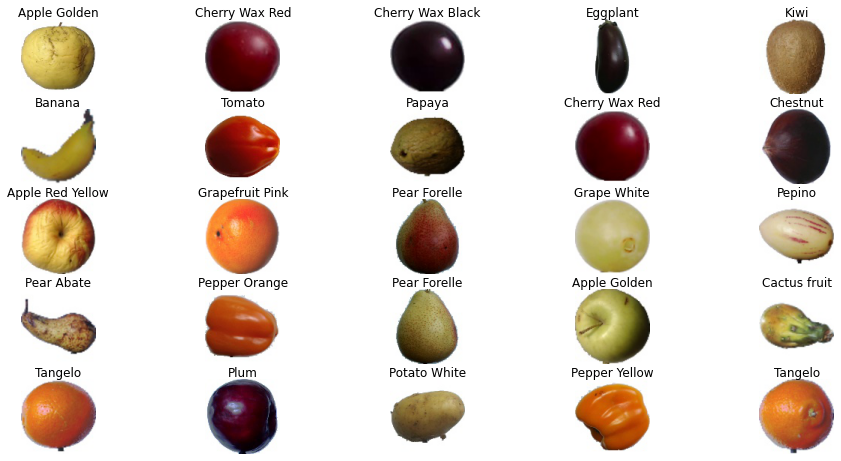

In [5]:
k = 25 
random_idx = np.random.randint(0 , len(train_images), k)

plt.figure(figsize=(16,8))
for i, rdm in enumerate(list(random_idx)):
    # loading the image
    img = load_image_array(str(train_images[rdm]))
    # plotting it in a grid 5x5
    plt.subplot(5,5,i+1)
    plt.imshow(img);
    plt.title(train_labels[rdm], y=.95)
    plt.axis('off')
plt.show()

## Splitting the data into training / validation since we already have "Test" data in a separate folder

In [6]:
from sklearn.preprocessing import LabelEncoder

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

# Using strings for the paths for convenience
X_train = [str(i) for i in X_train]
X_val = [str(i) for i in X_val]
# Using lists instead of pandas series for convenience again
y_train = y_train.tolist()
y_val = y_val.tolist()

# Encoding labels to numbers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

#### Making X_test in the same format (list for X and encoded labels for y)

In [7]:
X_test = [str(i) for i in test_images]
y_test = test_labels.tolist()
y_test = le.transform(y_test)

## Model building

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [10]:
batch_size = 32

callbacks_list = [ModelCheckpoint(monitor = 'val_loss',
                            filepath = 'cnn_basic.h5',
                            save_best_only = True,
                            save_weights_only = False,
                            verbose = 1),
                        EarlyStopping(monitor = 'val_loss',
                                    patience = 7,
                                    verbose = 1),
                        ReduceLROnPlateau(monitor = 'val_loss',
                                    factor = 0.1,
                                    patience = 3,
                                    verbose = 1)]

In [ ]:
history = model.fit(train_generator(X_train, y_train, batch_size, nb_classes, img_dim=100),
                    epochs=30,
                    steps_per_epoch = round(len(X_train)/batch_size),
                    validation_data=valid_generator(X_val, y_val, batch_size, nb_classes, img_dim=100),
                    validation_steps = round(len(X_val)/batch_size),
                    callbacks = callbacks_list,
                    verbose=1, shuffle=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1587 steps, validate for 529 steps
Epoch 1/30
1584/1587 [============================>.] - ETA: 0s - loss: 1.4613 - accuracy: 0.6096
Epoch 00001: val_loss improved from inf to 0.12370, saving model to cnn_basic.h5
1587/1587 [==============================] - 21s 13ms/step - loss: 1.4593 - accuracy: 0.6099 - val_loss: 0.1237 - val_accuracy: 0.9626
Epoch 2/30
1583/1587 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.9090
Epoch 00002: val_loss improved from 0.12370 to 0.08552, saving model to cnn_basic.h5
1587/1587 [==============================] - 20s 13ms/step - loss: 0.2772 - accuracy: 0.9091 - val_loss: 0.0855 - val_accuracy: 0.9712
Epoch 3/30
1585/1587 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9474
Epoch 00003: val_loss improved from 0.08552 to 0.02619, saving model to cnn_basic.h5
1587/1587 [==============================] - 20s 13ms/step - loss: 0.1648 - accuracy: 0.94